In [2]:
import random as rd
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO as io

In [3]:
def expRand(factor):
    #returns a random number between 0 and 1 from a 
    #sample of the form e^factor*x
    while True:
        xPos = rd.random()
        yPos = rd.random()
        if yPos < math.exp(factor*xPos):
            return xPos

# MODEL PARAMETERS

In [32]:
#day params
maxDays = 160

#bottle params
maxBottles = 1000 
bottleSize = 5 #Litres
bottleWeight = 0.129 #kg
PETemissionsPerKg = 1#kg
emissionsPerBottle = bottleWeight*PETemissionsPerKg  
maxLifespan = 20 #days, maximum time a bottle will last before breaking.
bottleRotationFactor = 2 #number of populations of rotating bottles

#sanitiser params
maxSani = maxBottles*bottleSize
minSani = 1 #Litres, the smallest allowable amount before resupply
studentsOnCampus = 25000
usesPerStudent = 6 #number of times a student will use sanitiser in a day.
LPerUse = 0.0016 
degSpeed = 25 #arbitrary units, the average speed at which a bottle degrades.
emissionsPerLSan = 0.01 #kg

#delivery params
supplyThreshold = 0.75 #fraction, the minimum unbroken bottles remaining before a resupply is required.
supplierDist = 45 #Kilometers, distance a supplier has to travel to Monash
emissionsPerKm = 0.113 #kg of carbon emissions per kilometer travelled.
supplyType = 0
deliveryType = 0

#cost params
workerHourlyRate = 30 #dollars
replaceInteractionTime = 20 #seconds, time taken to replace an empty sanitiser bottle
refillInteractionTime = replaceInteractionTime * 2 #seconds, time taken to refill an empty sanitiser bottle
storageInteractionTime = 30 #seconds, time taken to store each empty bottle
dirCostPerBottle = 50 #dollars, cost of each bottle in direct system
circCostPerBottle = 50 #dollars, cost of each bottle in circular system
deliveryCostPerKm = 2.92 #dollars per km
deliveryCostPerbottle = 2*(60/192)

#populations
CIRCPLASPOP = [0]
CIRCEMISPOP = [0]
CIRCCOSTPOP = [0]
CIRCSANIPOP = [0]

DIRPLASPOP = [0]
DIREMISPOP = [0]
DIRCOSTPOP = [0]

time = [0]

circPopulation = [0]
circAmount = [0]
circCategory = [0]

dirPopulation = [0]
dirAmount = [0]
dirCategory = [0]

# CIRCULAR MODEL
##### Supplier retrieves and drops off bottles in same trip.
##### Supplier refills bottles at factory, functionally the same as direct model for workers.

In [33]:
currentDay = 0
cycleDay = 0
currentBottles = 1000
currentSani = maxSani
wasteBottles = 0
while currentDay < maxDays:
    CIRCPLASPOP.append(CIRCPLASPOP[-1])
    CIRCEMISPOP.append(CIRCEMISPOP[-1])
    CIRCCOSTPOP.append(CIRCCOSTPOP[-1])
    
    degThreshold = ((maxLifespan*bottleRotationFactor-cycleDay)/(maxLifespan*bottleRotationFactor))
    brokenBottles = 0

    #supply reset loop
    if (maxBottles-wasteBottles)/maxBottles < supplyThreshold:

        #when the number of broken bottles reaches a certain point, the supplier 
        #replaces the remaining old bottles with a new set of
        #bottles and the life cycle restarts.
        cycleDay = 0      
        #increase plastic waste circPopulation by number of remaining old bottles
        CIRCPLASPOP[-1] += (maxBottles-wasteBottles)*bottleWeight
        #add production emissions of new bottles to replace the remaining old
        #ones to emission circPopulation
        CIRCEMISPOP[-1] += emissionsPerBottle*(maxBottles-wasteBottles)
        circAmount.append(emissionsPerBottle*(maxBottles - currentBottles))
        circCategory.append("bottle emissions")
        circPopulation.append("emissions")
        wasteBottles = 0

    
    #degradation loop
    for i in range(currentBottles):
        degFactor = expRand(-degSpeed)

        if degFactor > degThreshold:
            brokenBottles += 1
            wasteBottles += 1
            
    #removing broken bottles + adding to waste
    currentBottles -= brokenBottles
    CIRCPLASPOP[-1] += (brokenBottles)*bottleWeight

    #daily sani usage
    currentSani -= studentsOnCampus*usesPerStudent*LPerUse

    #restore Sani when sani drops below a certain circAmount
    if currentSani < minSani:
        currentSani = maxSani
        #adding purchase cost
        CIRCCOSTPOP[-1] += maxBottles*circCostPerBottle
        #charge information
        circAmount.append(maxBottles*circCostPerBottle)
        circCategory.append("bottlecost")
        circPopulation.append("costs")
        #adding replacement cost
        CIRCCOSTPOP[-1] += maxBottles*((replaceInteractionTime+storageInteractionTime) * (workerHourlyRate)/(60**2))
        #charge information
        circAmount.append(maxBottles*((replaceInteractionTime+storageInteractionTime) * (workerHourlyRate)/(60**2)))
        circCategory.append("work cost")
        circPopulation.append("costs")
        #add delivery cost.
        CIRCCOSTPOP[-1] += supplierDist*deliveryCostPerKm
        circAmount.append(supplierDist*deliveryCostPerKm)
        circCategory.append("delivery")
        circPopulation.append("costs")
        #adding delivery Emissions
        CIRCEMISPOP[-1] += (supplierDist*emissionsPerKm)
        circAmount.append(supplierDist*emissionsPerKm)
        circCategory.append("delivery emissions")
        circPopulation.append("emissions")
        #adding manufacture emissions
        CIRCEMISPOP[-1] += (maxBottles*bottleSize*emissionsPerLSan)
        circAmount.append(maxBottles*bottleSize*emissionsPerLSan)
        circCategory.append("manufacture emissions")
        circPopulation.append("emissions")
        
        #replacing broken bottles

        CIRCEMISPOP[-1] += emissionsPerBottle*(maxBottles - currentBottles)
        currentBottles = maxBottles
        circAmount.append(emissionsPerBottle*(maxBottles - currentBottles))
        circCategory.append("bottle emissions")
        circPopulation.append("emissions")
        
    time.append(currentDay)
    CIRCSANIPOP.append(currentSani)
    currentDay += 1
    cycleDay += 1

## SPECIFIC SUPPLIER MODEL

In [230]:
currentDay = 0
cycleDay = 0
currentBottles = 1000
currentSani = maxSani
wasteBottles = 0
while currentDay < maxDays:
    CIRCPLASPOP.append(CIRCPLASPOP[-1])
    CIRCEMISPOP.append(CIRCEMISPOP[-1])
    CIRCCOSTPOP.append(CIRCCOSTPOP[-1])
    
    degThreshold = ((maxLifespan*bottleRotationFactor-cycleDay)/(maxLifespan*bottleRotationFactor))
    brokenBottles = 0

    #supply reset loop
    if (maxBottles-wasteBottles)/maxBottles < supplyThreshold:

        #when the number of broken bottles reaches a certain point, the supplier 
        #replaces the remaining old bottles with a new set of
        #bottles and the life cycle restarts.
        cycleDay = 0      
        #increase plastic waste circPopulation by number of remaining old bottles
        CIRCPLASPOP[-1] += (maxBottles-wasteBottles)*bottleWeight
        #add production emissions of new bottles to replace the remaining old
        #ones to emission circPopulation
        CIRCEMISPOP[-1] += emissionsPerBottle*(maxBottles-wasteBottles)
        circAmount.append(emissionsPerBottle*(maxBottles - currentBottles))
        circCategory.append("bottle emissions")
        circPopulation.append("emissions")
        wasteBottles = 0

    
    #degradation loop
    for i in range(currentBottles):
        degFactor = expRand(-degSpeed)

        if degFactor > degThreshold:
            brokenBottles += 1
            wasteBottles += 1
            
    #removing broken bottles + adding to waste
    currentBottles -= brokenBottles
    CIRCPLASPOP[-1] += (brokenBottles)*bottleWeight

    #daily sani usage
    currentSani -= studentsOnCampus*usesPerStudent*LPerUse

    #restore Sani when sani drops below a certain circAmount
    if currentSani < minSani:
        currentSani = maxSani
        #adding purchase cost
        CIRCCOSTPOP[-1] += maxBottles*circCostPerBottle
        #charge information
        circAmount.append(maxBottles*circCostPerBottle)
        circCategory.append("bottlecost")
        circPopulation.append("costs")
        #adding replacement cost
        CIRCCOSTPOP[-1] += maxBottles*((replaceInteractionTime+storageInteractionTime) * (workerHourlyRate)/(60**2))
        #charge information
        circAmount.append(maxBottles*((replaceInteractionTime+storageInteractionTime) * (workerHourlyRate)/(60**2)))
        circCategory.append("work cost")
        circPopulation.append("costs")
        #add delivery cost.
        CIRCCOSTPOP[-1] += maxBottles*deliveryCostPerbottle
        circAmount.append(supplierDist*deliveryCostPerKm)
        circCategory.append("delivery")
        circPopulation.append("costs")
        #adding delivery Emissions
        CIRCEMISPOP[-1] += (supplierDist*emissionsPerKm)
        circAmount.append(supplierDist*gramPerKm)
        circCategory.append("delivery emissions")
        circPopulation.append("emissions")
        #adding manufacture emissions
        CIRCEMISPOP[-1] += (maxBottles*bottleSize*emissionsPerLSan)
        circAmount.append(maxBottles*bottleSize*emissionsPerLSan)
        circCategory.append("manufacture emissions")
        circPopulation.append("emissions")
        
        #replacing broken bottles

        CIRCEMISPOP[-1] += emissionsPerBottle*(maxBottles - currentBottles)
        currentBottles = maxBottles
        circAmount.append(emissionsPerBottle*(maxBottles - currentBottles))
        circCategory.append("bottle emissions")
        circPopulation.append("emissions")
        
    time.append(currentDay)
    CIRCSANIPOP.append(currentSani)
    currentDay += 1
    cycleDay += 1

# DIRECT MODEL

In [34]:
#DIRECT

currentDay = 0
cycleDay = 0
currentBottles = 1000
currentSani = maxSani

while currentDay < maxDays:

    DIRPLASPOP.append(DIRPLASPOP[-1])
    DIREMISPOP.append(DIREMISPOP[-1])
    DIRCOSTPOP.append(DIRCOSTPOP[-1])
    
    #daily sani usage
    currentSani -= studentsOnCampus*usesPerStudent*LPerUse
    
    if currentSani < minSani:
        currentSani = maxSani
        
        #purchase cost
        DIRCOSTPOP[-1] += maxBottles*dirCostPerBottle
        dirAmount.append(maxBottles*dirCostPerBottle)
        dirCategory.append("bottle")
        dirPopulation.append("costs")
        #delivery emissions
        DIREMISPOP[-1] += (supplierDist*emissionsPerKm)
        dirAmount.append(supplierDist*emissionsPerKm)
        dirCategory.append("delivery")
        dirPopulation.append("emissions")
        #production emissions
        DIREMISPOP[-1] += emissionsPerBottle*maxBottles
        dirAmount.append(emissionsPerBottle*maxBottles)
        dirCategory.append("bottle")
        dirPopulation.append("emissions")
        #replacement cost
        DIRCOSTPOP[-1] += maxBottles*(replaceInteractionTime * (workerHourlyRate)/(60**2))
        dirAmount.append(maxBottles*(replaceInteractionTime * (workerHourlyRate)/(60**2)))
        dirCategory.append("worker")
        dirPopulation.append("costs")
        #delivery cost
        DIRCOSTPOP[-1] += supplierDist*deliveryCostPerKm
        dirAmount.append(supplierDist*deliveryCostPerKm)
        dirCategory.append("delivery")
        dirPopulation.append("costs")
        #adding manufacture emissions
        DIREMISPOP[-1] += (maxBottles*bottleSize*emissionsPerLSan)
        dirAmount.append(maxBottles*bottleSize*emissionsPerLSan)
        dirCategory.append("manufacture emissions")
        dirPopulation.append("emissions")

        #increase plastic pop
        DIRPLASPOP[-1] += (currentBottles)*bottleWeight

    currentDay += 1


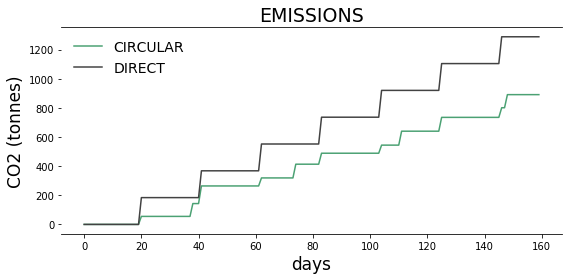

In [38]:
fig, ax1 = plt.subplots(figsize=(8,4))

ax1.set_title('EMISSIONS', fontsize = 19)
ax1.set_ylabel('CO2 (tonnes)', fontsize = 17)
ax1.set_xlabel('days', fontsize = 17)
ax1.set_yticklabels([0,0,0.2,0.4,0.6,0.8,1,1.2], Fontsize = 14)
ax1.set_xticklabels([0,0,20,40,60,80,100,120,140,160],Fontsize= 14)
ax1.plot(time, CIRCEMISPOP, label = 'CIRCULAR', color = '#4ba173')
ax1.plot(time, DIREMISPOP, label = 'DIRECT', color = '#424242')

ax1.legend(loc='upper left', frameon=False, fontsize = 14)
#ax1.spines["top"].set_visible(False)    
#ax1.spines["bottom"].set_visible(False)    
ax1.spines["right"].set_visible(False)    
ax1.spines["left"].set_visible(False) 


fig.tight_layout()
plt.show()

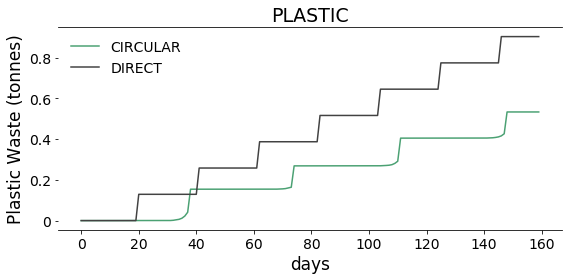

In [40]:

fig, ax1 = plt.subplots(figsize=(8,4))

ax1.set_title('PLASTIC', fontsize = 19)
ax1.set_ylabel('Plastic Waste (tonnes)', fontsize = 17)
ax1.set_xlabel('days', fontsize = 17)
ax1.set_yticklabels([0,0,0.2,0.4,0.6,0.8], Fontsize = 14)
ax1.set_xticklabels([0,0,20,40,60,80,100,120,140,160],Fontsize= 14)
ax1.plot(time, CIRCPLASPOP, label = 'CIRCULAR', color = '#4ba173')
ax1.plot(time, DIRPLASPOP, label = 'DIRECT', color = '#424242')

ax1.legend(loc='upper left', frameon=False, fontsize = 14)
  
ax1.spines["right"].set_visible(False)    
ax1.spines["left"].set_visible(False) 


fig.tight_layout()
plt.show()


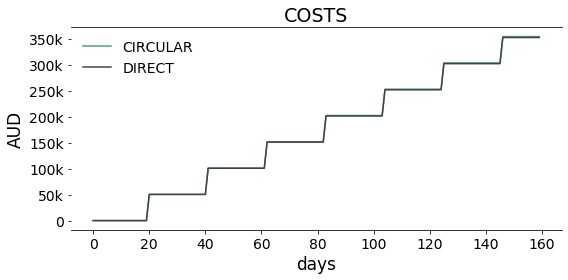

In [37]:
fig, ax1 = plt.subplots(figsize=(8,4))

ax1.set_title('COSTS', fontsize = 19)
ax1.set_ylabel('AUD', fontsize = 17)
ax1.set_xlabel('days', fontsize = 17)
ax1.set_yticklabels(['0','0','50k','100k','150k','200k','250k','300k','350k'], Fontsize = 14)
ax1.set_xticklabels([0,0,20,40,60,80,100,120,140,160],Fontsize= 14)
ax1.plot(time, CIRCCOSTPOP, label = 'CIRCULAR', color = '#4ba173')
ax1.plot(time, DIRCOSTPOP, label = 'DIRECT', color = '#424242')

ax1.legend(loc='upper left', frameon=False, fontsize = 14)
#ax1.spines["top"].set_visible(False)    
#ax1.spines["bottom"].set_visible(False)    
ax1.spines["right"].set_visible(False)    
ax1.spines["left"].set_visible(False) 


fig.tight_layout()
plt.show()

In [181]:
print('Measures of key metrics after 1 year of operation are:')
print(CIRCEMISPOP[-1], ' kg of CO2 Emitted')
print(CIRCPLASPOP[-1], ' kg of plastic used')
print('costing $',CIRCCOSTPOP[-1])

Measures of key metrics after 1 year of operation are:
1608.2279999999994  kg of CO2 Emitted
500.3910000000004  kg of plastic used
costing $ 792720.0


In [30]:
#CSV export

data = {
    'time':time,
    'circ plastic waste': CIRCPLASPOP,
    'circ emissions': CIRCEMISPOP,
    'circ costs': CIRCCOSTPOP,
    'dir plastic waste': DIRPLASPOP,
    'dir emissions': DIREMISPOP,
    'dir costs': DIRCOSTPOP}

df = pd.DataFrame(data)
df.to_csv('comparativeData.csv')



In [226]:
chargeData = {
    'population':circPopulation,
    'category':circCategory,
    'amount':circAmount}

chargeDf = pd.DataFrame(chargeData)
chargeDf.to_csv('circPopulationBreakdown.csv')


In [227]:
dirPopData = {
    'population':dirPopulation,
    'category':dirCategory,
    'amount':dirAmount}

dirPopDf = pd.DataFrame(dirPopData)
dirPopDf.to_csv('dirPopulationBreakdown.csv')



In [1]:
print(int(''))

ValueError: invalid literal for int() with base 10: ''